# Lab Two: Flow Matching and Score Matching

Welcome to lab two! In this lab, we will provide an intuitive and hands-on walk-through of *flow matching* and *score matching*. If you find any mistakes, or have any other feedback, please feel free to email us at `erives@mit.edu` and `phold@mit.edu`. Enjoy!

### Part 0: Miscellaneous Imports and Utility Functions
No questions here, but free to read through to familiarize yourself with these helper functions. Most of this is what you already completed in lab one!

In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    The Abstract Base Class or Interface defines objects that behave liuke distribution you can sample from.
    It does not implement the sampling! That is done by CONCRETE subclasses.
    If all abstract methods are not implemented by a subclass, an error will be raised.
    """
    @property
    @abstractmethod
    def dim(self) -> int:
        """
        Returns:
            - Dimensionality of the distribution
        The @property decorator is used to define a method that can be accessed like an attribute, i.e. obj.dim instead of obj.dim()
        """
        pass

    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, dim)
        """
        pass

class Density(ABC):
    """
    Distribution with tractable density
    """
    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the log density at x.
        Args:
            - x: shape (batch_size, dim)
        Returns:
            - log_density: shape (batch_size, 1)
        """
        pass

class Gaussian(torch.nn.Module, Sampleable, Density):
    """
    Multivariate Gaussian distribution
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        """
        mean: shape (dim,)
        cov: shape (dim,dim)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def dim(self) -> int:
        return self.mean.shape[0]

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))

    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

    @classmethod
    def isotropic(cls, dim: int, std: float) -> "Gaussian":
        mean = torch.zeros(dim)
        cov = torch.eye(dim) * std ** 2
        return cls(mean, cov)

class GaussianMixture(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian mixture model, and is a Density and a Sampleable. Wrapper around torch.distributions.MixtureSameFamily.
    Necessary to define a multivariate gaussian for each value of t (discrete time steps) x ~ N(alpha_t z, beta_t^2 I_d)
    """
    def __init__(
        self,
        means: torch.Tensor,  # nmodes x data_dim
        covs: torch.Tensor,  # nmodes x data_dim x data_dim
        weights: torch.Tensor,  # nmodes
    ):
        """
        means: shape (nmodes, 2)
        covs: shape (nmodes, 2, 2)
        weights: shape (nmodes, 1)
        """
        super().__init__()
        self.nmodes = means.shape[0]
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)

    @property
    def dim(self) -> int:
        return self.means.shape[1]

    @property
    def distribution(self):
        return D.MixtureSameFamily(
                mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
                component_distribution=D.MultivariateNormal(
                    loc=self.means,
                    covariance_matrix=self.covs,
                    validate_args=False,
                ),
                validate_args=False,
            )

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample(torch.Size((num_samples,)))

    @classmethod
    def random_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0, seed = 0.0
    ) -> "GaussianMixture":
        """
        Randomly initializes the means and covariances of the Gaussian mixture.

        Note: cls is the class itself, i.e. GaussianMixture, not an instance of the class. 
        It's the first parameter of a class method, just like self is the first parameter of an instance method.
        Using cls makes the method work with inheritance: if a subclass of GaussianMixture implements a different random_2D method,
        the subclass's method will be used instead of the parent class's.
        
        """
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale + x_offset * torch.Tensor([1.0, 0.0])
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        weights = torch.ones(nmodes)
        return cls(means, covs, weights) # Same as: GaussianMixture(means, covs, weights)

    @classmethod
    def symmetric_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0
    ) -> "GaussianMixture":
        """
        Initializes a Gaussian mixture with equal weights and means on the unit circle.
        """
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale + torch.Tensor([1.0, 0.0]) * x_offset
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

In [3]:
# Several plotting utility functions
def hist2d_samples(samples, ax: Optional[Axes] = None, bins: int = 200, scale: float = 5.0, percentile: int = 99, **kwargs):
    H, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=bins, range=[[-scale, scale], [-scale, scale]])

    # Determine color normalization based on the 99th percentile
    cmax = np.percentile(H, percentile)
    cmin = 0.0
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    # Plot using imshow for more control
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(H.T, extent=extent, origin='lower', norm=norm, **kwargs)

def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, bins=200, scale: float = 5.0, percentile: int = 99, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples).detach().cpu() # (ns, 2)
    hist2d_samples(samples, ax, bins, scale, percentile, **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def kdeplot_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    sns.kdeplot(x=samples[:,0].cpu(), y=samples[:,1].cpu(), ax=ax, **kwargs)

def imshow_density(density: Density, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float], bins: int, ax: Optional[Axes] = None, x_offset: float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    x = torch.linspace(x_min, x_max, bins).to(device) + x_offset
    y = torch.linspace(y_min, y_max, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent=[x_min, x_max, y_min, y_max], origin='lower', **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, x_offset:float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale + x_offset, scale + x_offset, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), origin='lower', **kwargs)

In [5]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE, i.e. the vector field u_t(x)
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (batch_size, 1)
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE, i.e. sigma_t
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape (batch_size, 1)
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape (batch_size, 1)
        Returns:
            - diffusion_coefficient: shape (batch_size, dim)
        """
        pass

In [6]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (bs,1)
            - dt: time, shape (bs,1)
        Returns:
            - nxt: state at time t + dt (bs, dim)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (bs, num_timesteps,1)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)

        The @torch.no_grad() decorator is used to disable gradient calculation for the function.
        When you are not training you don't need to compute gradients. It speeds up the computation.
        """
        for t_idx in range(len(ts) - 1):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization given by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (bs, num_timesteps, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num
            _timesteps, dim)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.ode.drift_coefficient(xt,t) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.sde.drift_coefficient(xt,t) * h + self.sde.diffusion_coefficient(xt,t) * torch.sqrt(h) * torch.randn_like(xt)

def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

### Part 1: Implementing Conditional Probability Paths
Recall from lecture and the class notes the basic premise of conditional flow matching: describe a *conditional probability path* $p_t(x|z)$, so that $p_1(x|z) = \delta_z(x)$, and $p_0(z) = p_{\text{simple}}$ (e.g., a Gaussian), and $p_t(x|z)$ interpolates continuously (we are not being rigorous here) between $p_0(x|z)$ and $p_1(x|z)$. Such a conditional path can be seen as corresponding to some corruption process which (in reverse time) drives the point $z$ at $t=1$ to be distribution as $p_0(x|z)$ at time $t=0$. Such a corruption process is given by the ODE
$$dX_t = u_t^{\text{ref}}(X_t|z)\,dt,\quad \quad X_0 \sim p_{\text{simple}}.$$
The drift $u_t^{\text{ref}}(X_t|z)$ is referred to as the *conditional vector field*. By averaging $u_t^{\text{ref}}(x|z)$ over all such choices of $z$, we obtain the *marginal* vector field $u_t^{\text{ref}}(x)$. Flow matching proposes to exploit the fact that the *marginal probability path* $p_t(x)$ generated by the marginal vector field $u_t^{\text{ref}}(x)$, bridges $p_{\text{simple}}$ to $p_{\text{data}}$. Since the conditional vector field $u_t^{\text{ref}}(x|z)$ is often analytically available, we may implicitly regress against the unknown marginal vector field $u_t^{\text{ref}}(x)$ by explicitly regressing against the conditional vector field $u_t^{\text{ref}}(x|z)$.

The central object in this construction is a *conditional probability path*, whose interface is implemented below in the class `ConditionalProbabilityPath`. In this lab, you will implement two subclasses: `GaussianConditionalProbabilityPath`, and `LinearConditionalProbabilityPath` corresponding to probability paths of the same names from the lectures and notes.

In [7]:
class ConditionalProbabilityPath(torch.nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, dim)
        """
        num_samples = t.shape[0]
        # Sample conditioning variable z ~ p(z)
        z = self.sample_conditioning_variable(num_samples) # (num_samples, dim)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, dim)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        pass

    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        pass

    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_score: conditional score (num_samples, dim)
        """
        pass

# Part 2: Gaussian Conditional Probability Paths
In this section, we'll implement a **Gaussian conditional probability path** via the class `GaussianConditionalProbabilityPath`. We will then use it to transform a simple source $p_{\text{simple}} = N(0, I_d)$ into a Gaussian mixture $p_{\text{data}}$. Later, we'll experiment with more exciting distributions. Recall that a Gaussian conditional probability path is given by
$$p_t(x|z) = N(x;\alpha_t z,\beta_t^2 I_d),\quad\quad\quad p_{\text{simple}}=N(0,I_d),$$
where $\alpha_t: [0,1] \to \mathbb{R}$ and $\beta_t: [0,1] \to \mathbb{R}$ are monotonic, continuously differentiable functions satisfying $\alpha_1 = \beta_0 = 1$ and $\alpha_0 = \beta_1 = 0$. In other words, this implies that $p_1(x|z) = \delta_z$ and $p_0(x|z) = N(0, I_d)$ is a unit Gaussian. Before we dive into things, let's take a look at $p_{\text{simple}}$ and $p_{\text{data}}$.

In [8]:
# Constants for the duration of our use of Gaussian conditional probability paths, to avoid polluting the namespace...
PARAMS = {
    "scale": 15.0,
    "target_scale": 10.0,
    "target_std": 1.0,
}

/Users/davideprovasoli/Desktop/Diffusion Models/.venv/lib/python3.13/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


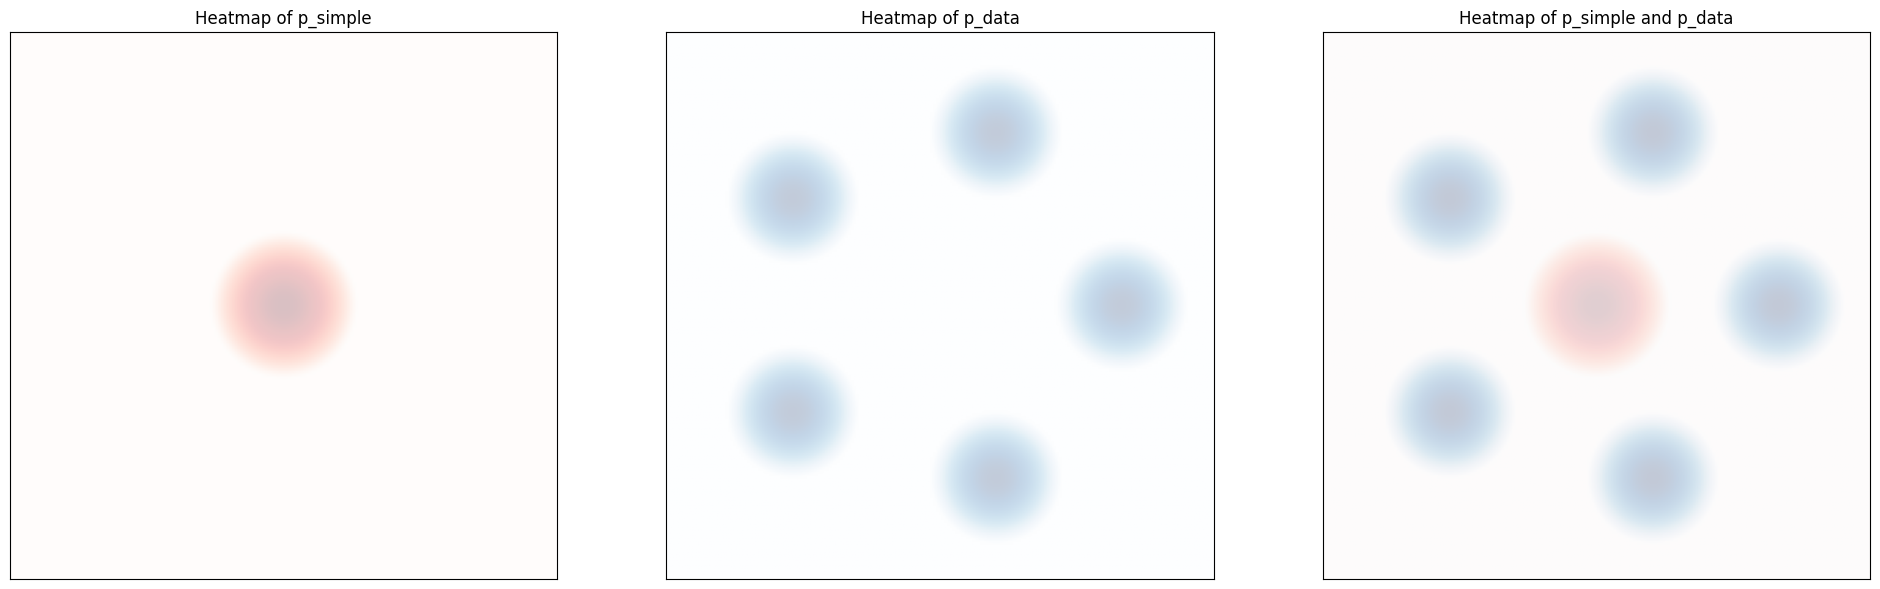

In [ ]:
p_simple = Gaussian.isotropic(dim=2, std = 1.0).to(device) ## .to(device) moves the distribution's tensor to the device (CPU or GPU)
p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device)

fig, axes = plt.subplots(1,3, figsize=(24,8))
bins = 200

scale = PARAMS["scale"] ## scalesets the plotting/viewing window for visualizations.
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]

axes[0].set_title('Heatmap of p_simple')
axes[0].set_xticks([])
axes[0].set_yticks([])
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[0], vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))


axes[1].set_title('Heatmap of p_data')
axes[1].set_xticks([])
axes[1].set_yticks([])
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[1], vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

axes[2].set_title('Heatmap of p_simple and p_data')
axes[2].set_xticks([])
axes[2].set_yticks([])
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

### Problem 2.1: Implementing $\alpha_t$ and $\beta_t$

Let's get started by implementing $\alpha_t$ and $\beta_t$. We can think of these simply as callable objects which fulfill the simple contract $\alpha_1 = \beta_0 = 1$ and $\alpha_0 = \beta_1 = 0$, and which can compute their time derivatives $\dot{\alpha}_t$ and $\dot{\beta}_t$. We implement them below via the classes `Alpha` and `Beta`.

In [10]:
class Alpha(ABC):
    def __init__(self):
        # Check alpha_t(0) = 0
        assert torch.allclose( ## torch.allclose() checks if two tensors are element-wise close within a tolerance.
            self(torch.zeros(1,1)), torch.zeros(1,1) ## torch.ones(1,1) creates a 1x1 tensor with all elements set to 0.
        )
        # Check alpha_1 = 1
        assert torch.allclose(
            self(torch.ones(1,1)), torch.ones(1,1)  ## torch.ones(1,1) creates a 1x1 tensor with all elements set to 1.
        )

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - alpha_t (num_samples, 1)
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        Note:
              vmap vectorizes the function over the batch dimension and pushes it to the device.
              jacrev computes the jacobian of the function with respect to the input.
        """
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = vmap(jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)

class Beta(ABC):
    def __init__(self):
        # Check beta_0 = 1
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.ones(1,1)
        )
        # Check beta_1 = 0
        assert torch.allclose(
            self(torch.ones(1,1)), torch.zeros(1,1)
        )

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt beta_t (num_samples, 1)
        """
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = vmap(jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)

In this section, we'll be using $$\alpha_t = t \quad \quad \text{and} \quad \quad \beta_t = \sqrt{1-t}.$$ It is not hard to check that both functions are continuously differentiable on $[0,1)$, and monotonic, that $\alpha_1 = \beta_0 = 1$, and that $\alpha_0 = \beta_1 = 0$.

**Your job**: Implement the `__call__` methods of the classes `LinearAlpha` and `SquareRootBeta` below.

In [11]:
class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - alpha_t (num_samples, 1)
        """
        return t
        raise NotImplementedError("Fill me in for Question 2.1!")

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """
        return torch.ones_like(t)

class SquareRootBeta(Beta):
    """
    Implements beta_t = rt(1-t)
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """
        return torch.sqrt(1 - t)
        raise NotImplementedError("Fill me in for Question 2.1!")

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """
        return - 0.5 / (torch.sqrt(1 - t) + 1e-4)

Let us know turn towards the task of implementing the `GaussianConditionalProbabilityPath` path.

In [20]:
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, alpha: Alpha, beta: Beta):
        p_simple = Gaussian.isotropic(p_data.dim, 1.0)
        super().__init__(p_simple, p_data) 
        ## super() lets you call parent class methods from a subclass, which is essential for proper initialization and method overriding in object-oriented Python.
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z ~ p_data(x)
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        return p_data.sample(num_samples)

    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        return z * self.alpha(t) + torch.randn_like(z) * self.beta(t)
        raise NotImplementedError("Fill me in for Question 2.2!")

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """
        return (self.alpha.dt(t)-self.beta.dt(t)*self.alpha(t)/self.beta(t)) * z + (self.beta.dt(t)/self.beta(t))*x
        raise NotImplementedError("Fill me in for Question 2.3!")

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_score: conditional score (num_samples, dim)
        """
        raise NotImplementedError("Fill me in for Question 2.4!")

### Problem 2.2: Gaussian Conditional Probability Path

**Your work**: Implement the class method `sample_conditional_path` to sample from the conditional distribution $p_t(x|z) = N(x;\alpha_t z,\beta_t^2 I_d)$. You can check the correctness of your implementation by running the next two cells to generate an image of the conditional probability path and comparing these to the corresponding plot from Figure 6 in the lecture notes (the one labeled "Ground-Truth Conditional Probability Path").

**Hint**: You may use the fact that the random variable $X \sim N(\mu, \sigma^2 I_d)$ is obtained via $X = \mu + \sigma Z$, where $Z \sim N(0, I_d)$.

We can now sample from, and thus visualize, the *conditional* probaability path.

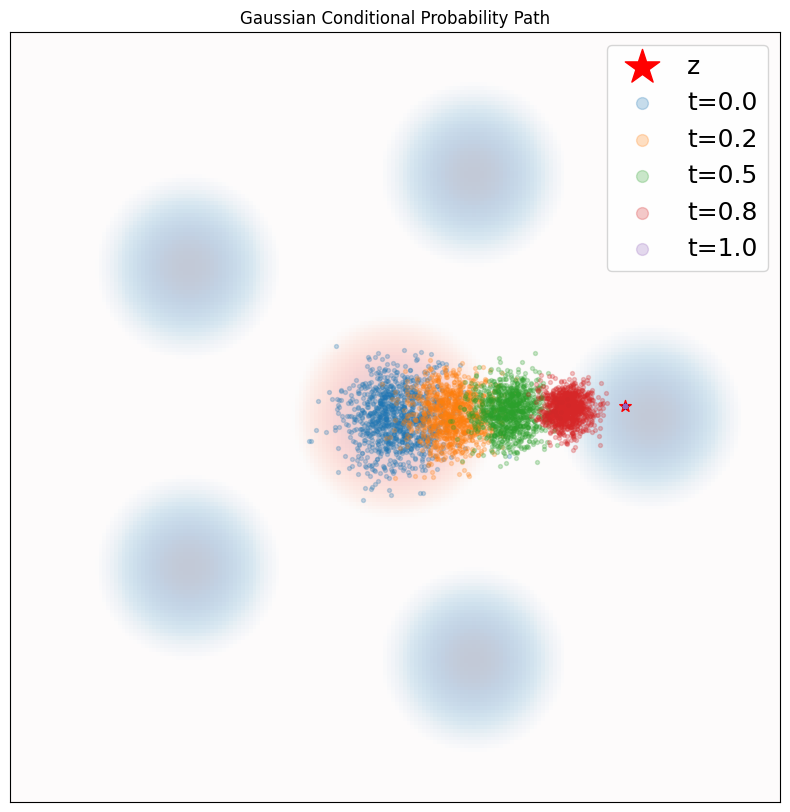

In [19]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]

plt.figure(figsize=(10,10))
plt.xlim(*x_bounds)
plt.ylim(*y_bounds)
plt.title('Gaussian Conditional Probability Path')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

# Sample conditioning variable z
z = path.sample_conditioning_variable(1) # (1,2)
ts = torch.linspace(0.0, 1.0, 5).to(device)

# Plot z
plt.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=75, label='z')
plt.xticks([])
plt.yticks([])

# Plot conditional probability path at each intermediate t
num_samples = 1000
for t in ts:
    zz = z.expand(num_samples, 2)
    tt = t.unsqueeze(0).expand(num_samples, 1) # (samples, 1)
    samples = path.sample_conditional_path(zz, tt) # (samples, 2)
    plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), alpha=0.25, s=8, label=f't={t.item():.1f}')

plt.legend(prop={'size': 18}, markerscale=3)
plt.show()

### Problem 2.3: Conditional Vector Field
From lecture and the notes, we know that the conditional vector field $u_t(x|z)$ is given by
$$u_t(x|z) = \left(\dot{\alpha}_t-\frac{\dot{\beta}_t}{\beta_t}\alpha_t\right)z+\frac{\dot{\beta}_t}{\beta_t}x.$$

**Your work**: Implement the class method `conditional_vector_field` to compute the conditional vector field $u_t(x|z)$.

**Hint**: You can compute $\dot{\alpha}_t$ with `self.alpha.dt(t)`, which has been implemented for you. You may compute $\dot{\beta}_t$ similarly.

We may now visualize the conditional trajectories corresponding to the ODE $$d X_t = u_t(X_t|z)dt, \quad \quad X_0 = x_0 \sim p_{\text{simple}}.$$

In [22]:
class ConditionalVectorFieldODE(ODE):
    def __init__(self, path: ConditionalProbabilityPath, z: torch.Tensor):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.path = path
        self.z = z

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t)

100%|██████████| 999/999 [00:00<00:00, 19756.75it/s]


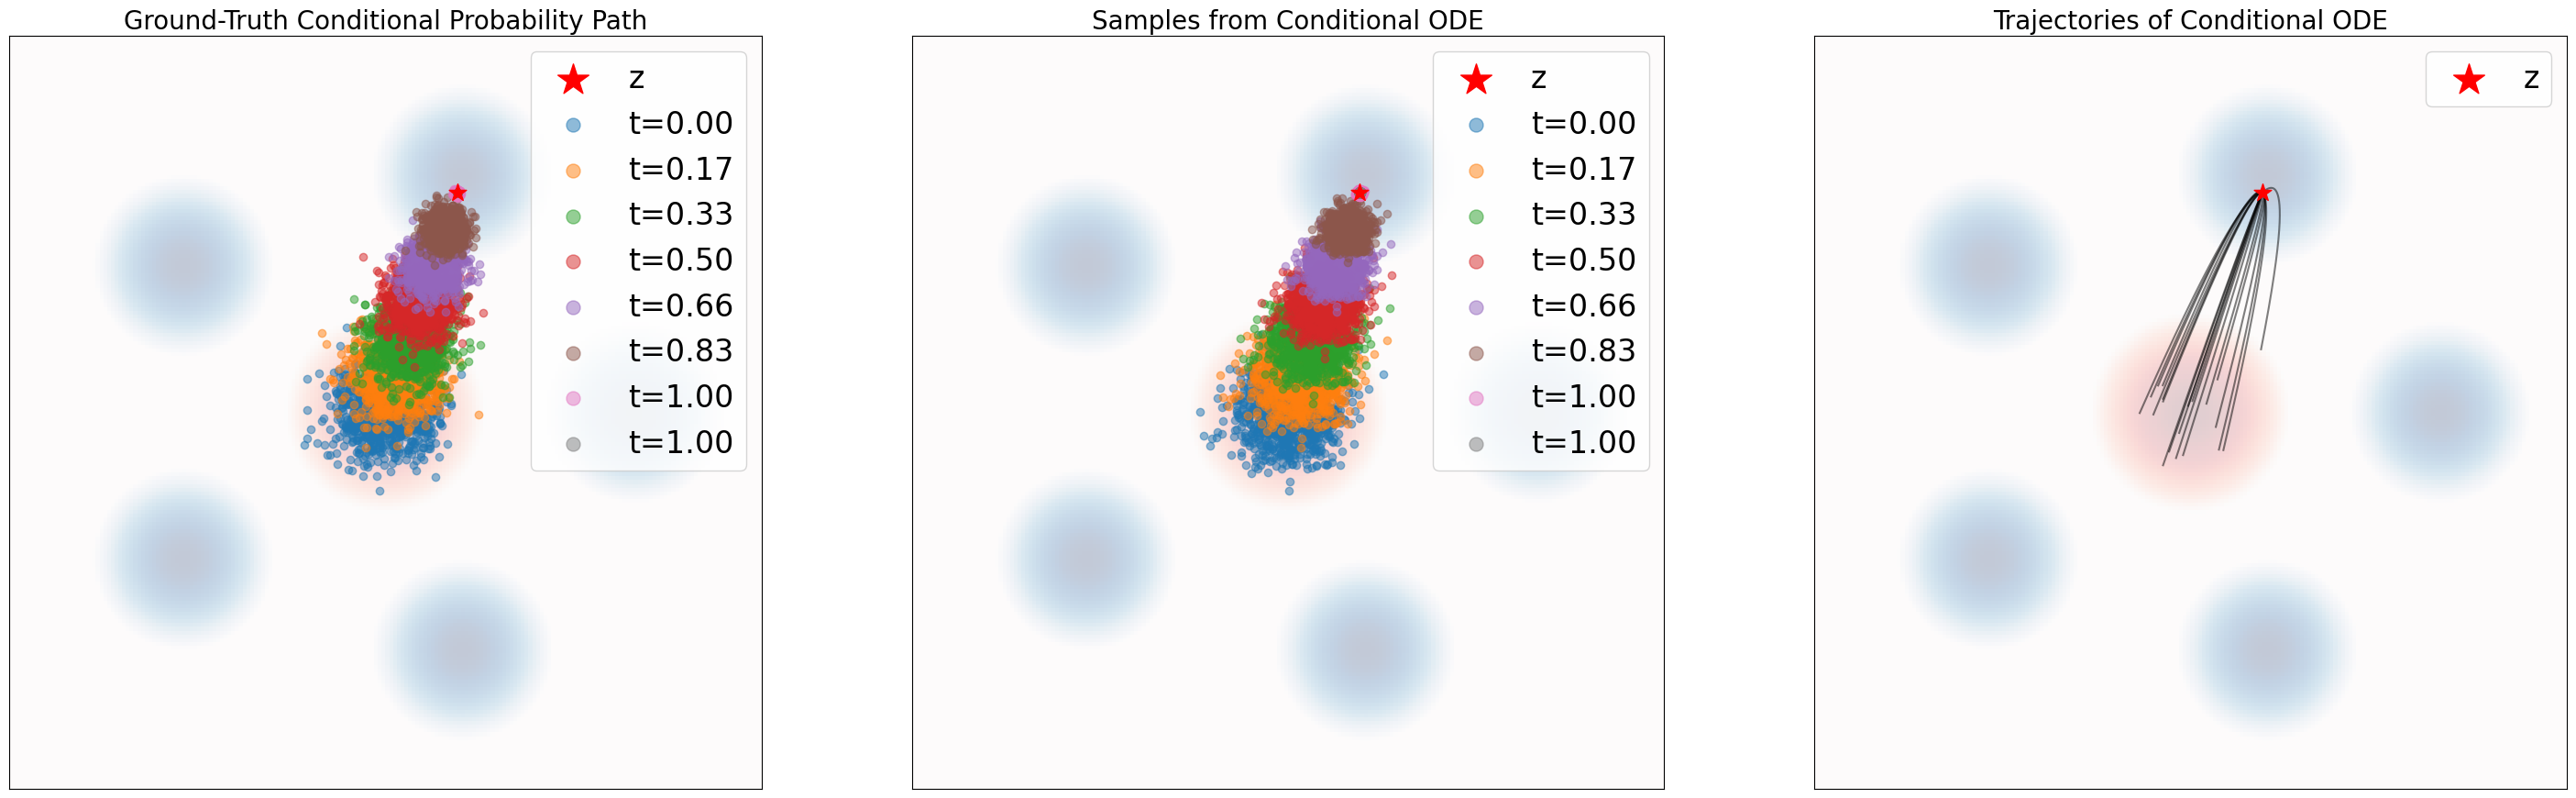

In [25]:
# Run me for Problem 2.3!

#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 6

########################
# Setup path and plot  #
########################

path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)


# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))
scale = PARAMS["scale"]
legend_size = 24
markerscale = 1.8
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]

# Sample conditioning variable z
torch.cuda.manual_seed(1) # sets the seed for the random number generator, so each time you run the code you get the same random numbers.
z = path.sample_conditioning_variable(1) # (1,2)

######################################
# Graph samples from conditional ODE #
######################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Samples from Conditional ODE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
sigma = 0.5 # Can't make this too high or integration is numerically unstable!
ode = ConditionalVectorFieldODE(path, z)
simulator = EulerSimulator(ode)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
## .view(1,-1,1) Reshapes to: (1, num_timesteps, 1)
## Example: (1, 100, 1), The -1 means "infer this dimension" 
## .expand(num_samples,-1,1) repeats the tensor along the first dimension (num_samples times), i.e. reshapes to (num_samples, num_timesteps, 1)
## final result: (num_samples, num_timesteps, 1) in GPU/CPU 
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):  ## If xts_every_n has shape (50, 11, 2), then shape[1] = 11
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


#########################################
# Graph Trajectories of Conditional ODE #
#########################################
ax = axes[2]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Trajectories of Conditional ODE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(20):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


###################################################
# Graph Ground-Truth Conditional Probability Path #
###################################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Ground-Truth Conditional Probability Path', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    zz = z.expand(num_samples, 2)
    marginal_samples = path.sample_conditional_path(zz, tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()

**Note**: You may have noticed that since for Gaussian probability paths, $z \sim p_{\text{data}}(x)$, the method `GaussianConditionalProbabilityPath.sample_conditioning_variable` is effectively sampling from the data distribution. But wait - aren't we trying to learn to sample from $p_{\text{data}}$ in the first place? This is a subtlety that we have glossed over thus far. The answer is that *in practice*, `sample_conditioning_variable` would return points from a finite *training set*, which is formally assumed to have been sampled IID from the true distribution $z \sim p_{\text{data}}$.

### Problem 2.4: The Conditional Score

As in lecture may now visualize the conditional trajectories corresponding to the SDE $$d X_t = \left[u_t(X_t|z) + \frac{1}{2}\sigma_t^2 \nabla_x \log p_t(X_t|z) \right]dt + \sigma\, dW_t, \quad \quad X_0 = x_0 \sim p_{\text{simple}},$$
obtained by adding *Langevin dynamics* to the original ODE.

**Your work**: Implement the class method `conditional_score` to compute the conditional distribution $\nabla_x \log p_t(x|z)$, which we compute to be
$$\nabla_x \log p_t(x|z) = \nabla_x N(x;\alpha_t z,\beta_t^2 I_d) = \frac{\alpha_t z - x}{\beta_t^2}.$$
To check for correctness, use the next two cells to verify that samples from the conditional SDE match the samples drawn analytically from the conditional probability path.

In [ ]:
class ConditionalVectorFieldSDE(SDE):
    def __init__(self, path: ConditionalProbabilityPath, z: torch.Tensor, sigma: float):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, ...)
        """
        super().__init__()
        self.path = path
        self.z = z
        self.sigma = sigma

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t) + 0.5 * self.sigma**2 * self.path.conditional_score(x,z,t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)

**Note**: You may notice that strange things happen for large (or even not-so-large) values of $\sigma$. Plugging in $$\nabla_x \log p_t(x|z) = \frac{\alpha_t z - x}{\beta_t^2}$$ into $$d X_t = \left[u_t(X_t|z) + \frac{1}{2}\sigma^2 \nabla_x \log p_t(X_t|z) \right]dt + \sigma\, dW_t$$ yields
$$d X_t = \left[u_t(X_t|z) + \frac{1}{2}\sigma^2 \left(\frac{\alpha_t z - X_t}{\beta_t^2}\right) \right]dt + \sigma\, dW_t.$$
When $t \to 1$, $\beta_t \to 0$, so that the second term of the drift explodes (and this explosion scales quadratically with $\sigma$). With a finite number of simulation steps, we cannot accurately simulate this explosion and thus encounter numerical issues. In practice, this is usually circumvented by setting e.g., $\sigma_t = \beta_t$, so that the exploding affect is canceled out by a gradually decreasing noise level.

In [ ]:
# Run me for Problem 2.3!

#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3
sigma = 2.5

########################
# Setup path and plot  #
########################

path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)


# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))
scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size = 24
markerscale = 1.8

# Sample conditioning variable z
torch.cuda.manual_seed(1)
z = path.sample_conditioning_variable(1) # (1,2)

######################################
# Graph Samples from Conditional SDE #
######################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Samples from Conditional SDE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
sde = ConditionalVectorFieldSDE(path, z, sigma)
simulator = EulerMaruyamaSimulator(sde)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


##########################################
# Graph Trajectories of Conditional SDE  #
##########################################
ax = axes[2]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Trajectories of Conditional SDE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(5):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


###################################################
# Graph Ground-Truth Conditional Probability Path #
###################################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Ground-Truth Conditional Probability Path', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    zz = z.expand(num_samples, 2)
    marginal_samples = path.sample_conditional_path(zz, tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()

# Part 3: Flow Matching and Score Matching with Gaussian Conditional Probability Paths


### Problem 3.1 Flow Matching with Gaussian Conditional Probability Paths

Recall now that from lecture that our goal is to learn the *marginal vector field* $u_t(x)$ given by $$u_t^{\text{ref}}(x) = \mathbb{E}_{z \sim p_t(z|x)}\left[u_t^{\text{ref}}(x|z)\right].$$
Unfortunately, we don't actually know what $u_t^{\text{ref}}(x)$ is! We will thus approximate $u_t^{\text{ref}}(x)$ as a neural network $u_t^{\theta}(x)$, and exploit the identity $$ u_t^{\text{ref}}(x) = \text{argmin}_{u_t(x)} \,\,\mathbb{E}_{z \sim p_t(z|x)} \left[\lVert u_t(x) - u_t^{\text{ref}}(x|z)\rVert^2\right]$$ to obtain the **conditional flow matching objective**
$$ \mathcal{L}_{\text{CFM}}(\theta) = \,\,\mathbb{E}_{z \sim p(z), x \sim p_t(x|z)} \left[\lVert u_t^{\theta}(x) - u_t^{\text{ref}}(x|z)\rVert^2\right].$$
To model $u_t^{\theta}(x)$, we'll use a simple MLP. This network will take in both $x$ and $t$, and will return the learned vector field $u_t^{\theta}(x)$.

In [ ]:
def build_mlp(dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
        mlp = []
        for idx in range(len(dims) - 1):
            mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
            if idx < len(dims) - 2:
                mlp.append(activation())
        return torch.nn.Sequential(*mlp)

class MLPVectorField(torch.nn.Module):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """
    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - u_t^theta(x): (bs, dim)
        """
        xt = torch.cat([x,t], dim=-1)
        return self.net(xt)

Let's first define a general-purpose class `Trainer` to keep things tidy as we start training.

In [ ]:
class Trainer(ABC):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item()}')

        # Finish
        self.model.eval()

**Your work**: Fill in `ConditionalFlowMatchingTrainer.get_train_loss` below. This function should implement the conditional flow matching objective $$\mathcal{L}_{\text{CFM}}(\theta) = \,\,\mathbb{E}_{\textcolor{blue}{t \in \mathcal{U}[0,1), z \sim p(z), x \sim p_t(x|z)}} \textcolor{green}{\lVert u_t^{\theta}(x) - u_t^{\text{ref}}(x|z)\rVert^2}$$
using a Monte-Carlo estimate of the form
$$\frac{1}{N}\sum_{i=1}^N \textcolor{green}{\lVert u_{t_i}^{\theta}(x_i) - u_{t_i}^{\text{ref}}(x_i|z_i)\rVert^2}, \quad \quad \quad \forall i\in[1, \dots, N]: \textcolor{blue}{\,z_i \sim p_{\text{data}},\, t_i \sim \mathcal{U}[0,1),\, x_i \sim p_t(\cdot | z_i)}.$$
Here, $N$ is our *batch size*.


**Hint 1**: For sampling:
- You can sample `batch_size` points $z$ from $p_{\text{data}}$ using `self.path.p_data.sample(batch_size)`.
- You can sample `batch_size` values of `t` using `torch.rand(batch_size, 1)`.
- You can sample `batch_size` points from `p_t(x|z)` using `self.path.sample_conditional_path(z,t)`.

**Hint 2**: For the loss function:
- You can access $u_t^{\theta}(x)$ using `self.model(x,t)`.
- You can access $u_t^{\text{ref}}(x|z)$ using `self.path.conditional_vector_field(x,z,t)`.

In [ ]:
class ConditionalFlowMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: MLPVectorField, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        raise NotImplementedError("Fill me in for Question 3.1!")

Now let's train! This may take about a minute... **Remember, the loss should converge, but not to zero!**

In [ ]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

# Construct learnable vector field
flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, flow_model)
losses = trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=1000)

Is our model any good? Let's visualize? First, we need to wrap our learned vector field in an subclass of `ODE` so that we can simulate it using our `Simulator` class.

In [ ]:
class LearnedVectorFieldODE(ODE):
    def __init__(self, net: MLPVectorField):
        self.net = net

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: (bs, dim)
            - t: (bs, dim)
        Returns:
            - u_t: (bs, dim)
        """
        return self.net(x, t)

In [ ]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3


##############
# Setup Plot #
##############

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size=24
markerscale=1.8

# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))

###########################################
# Graph Samples from Learned Marginal ODE #
###########################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Samples from Learned Marginal ODE", fontsize=20)

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

##############################################
# Graph Trajectories of Learned Marginal ODE #
##############################################
ax = axes[2]
ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(num_samples // 10):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

################################################
# Graph Ground-Truth Marginal Probability Path #
################################################
ax = axes[0]
ax.set_title("Ground-Truth Marginal Probability Path", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    marginal_samples = path.sample_marginal_path(tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()

### Problem 3.2: Score Matching with Gaussian Conditional Probability Paths

We have thus far used flow matching to train a model $u_t^{\theta}(x) \approx u_t^{\text{ref}}$ so that $$d X_t = u_t^{\theta}(X_t) dt $$ approximately passes through the desired marginal probability path $p_t(x)$. Now recall from lecture that we may augment the reference marginal vector field $u_t^{\text{ref}}(x)$ with *Langevin dynamics* to add stochasticity while preserving the marginals, viz., $$dX_t = \left[u_t^{\text{ref}}(x) + \frac{1}{2}\sigma^2 \nabla \log p_t(x)\right] dt + \sigma d W_t.$$
Substituting our learned approximation $u_t^{\theta}(x) \approx u_t^{\text{ref}}$ therefore yields
$$dX_t = \left[u_t^{\theta}(x) + \frac{1}{2}\sigma^2 \nabla \log p_t(x)\right] dt + \sigma d W_t.$$
There's just one issue, what's the marginal score $\nabla \log p_t(x)$? In Question 2.3, we computed the conditional score $\nabla \log p_t(x|z)$ of the Gaussian probability path. In the same way that we learned an approximation $u_t^{\theta}(x) \approx u_t^{\text{ref}}$, we'd like to be able to learn a similar approximation $s_t^{\theta}(x) \approx \nabla \log p_t(x)$. Recall from lecture the identity $$\nabla \log p_t(x) = \mathbb{E}_{z \sim p_t(z|x)}\left[\nabla \log p_t(x|z) \right].$$ It then immediately follows that
$$\nabla \log p_t(x) = \text{argmin}_{s_t(x)} \,\,\mathbb{E}_{z \sim p(z), x \sim p_t(x|z)} \left[\lVert s_t(x) - \nabla \log p_t(x|z)\rVert^2\right].$$
We thus obtain the **conditional score matching** loss
$$\mathcal{L}_{\text{CSM}}(\theta) \triangleq \mathbb{E}_{t \sim \mathcal{U}[0,1), z \sim p(z), x \sim p_t(x|z)} \left[\lVert s_t^{\theta}(x) - \nabla \log p_t(x|z)\rVert^2\right].$$
Here, we will parameterize $s_t^{\theta}(x): \mathbb{R}^2 \to \mathbb{R}^2$ as a simple MLP, just like $u_t^{\theta}(x)$.

**Your job**: Fill in method `ConditionalScoreMatchingTrainer.get_train_loss` to implement the conditional score matching loss $\mathcal{L}_{\text{CSM}}(\theta)$.

**Hint:** Remember to re-use your implementation of `GaussianConditionalProbabilityPath.conditional_score`!

In [ ]:
class MLPScore(torch.nn.Module):
    """
    MLP-parameterization of the learned score field
    """
    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - s_t^theta(x): (bs, dim)
        """
        xt = torch.cat([x,t], dim=-1)
        return self.net(xt)

class ConditionalScoreMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: MLPScore, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        raise NotImplementedError("Fill me in for Question 3.2!")

Now let's train! **Remember, the loss should converge, but not to zero!**

In [ ]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

# Construct learnable vector field
score_model = MLPScore(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalScoreMatchingTrainer(path, score_model)
losses = trainer.train(num_epochs=1000, device=device, lr=1e-3, batch_size=1000)

Now let's visualize our work! Before we do however, we'll need to wrap our learned our flow model and score model in an instance of `SDE` so that we can integrate it using our `EulerMaruyamaIntegrator` class. This new class, `LangevinFlowSDE` will correspond to the dynamics $$dX_t = \left[u_t^{\theta}(x) + \frac{1}{2}\sigma^2 s_t^{\theta}(x)\right] dt + \sigma d W_t.$$

In [ ]:
class LangevinFlowSDE(SDE):
    def __init__(self, flow_model: MLPVectorField, score_model: MLPScore, sigma: float):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.flow_model = flow_model
        self.score_model = score_model
        self.sigma = sigma

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.flow_model(x,t) + 0.5 * self.sigma ** 2 * self.score_model(x, t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)

In [ ]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 300
num_marginals = 3
sigma = 2.0 # Don't set sigma too large or you'll get numerical issues!


##############
# Setup Plot #
##############

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size = 24
markerscale = 1.8

# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))

###########################################
# Graph Samples from Learned Marginal SDE #
###########################################
ax = axes[1]
ax.set_title("Samples from Learned Marginal SDE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
sde = LangevinFlowSDE(flow_model, score_model, sigma)
simulator = EulerMaruyamaSimulator(sde)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

###############################################
# Graph Trajectories of Learned Marginal SDE  #
###############################################
ax = axes[2]
ax.set_title("Trajectories of Learned Marginal SDE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(num_samples // 10):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

################################################
# Graph Ground-Truth Marginal Probability Path #
################################################
ax = axes[0]
ax.set_title("Ground-Truth Marginal Probability Path", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    marginal_samples = path.sample_marginal_path(tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()

### Question 3.3: Deriving the Marginal Score from the Marginal Flow
Recall from the notes and the lecture that for Gaussian probability paths $$u_t^{\text{ref}}(x) = a_tx + b_t\nabla \log p_t^{\text{ref}}(x).$$

where $(a_t, b_t) = \left(\frac{\dot{\alpha}_t}{\alpha_t}, \beta_t^2 \frac{\dot{\alpha}_t}{\alpha_t} - \dot{\beta}_t \beta_t\right)$. Rearranging yields $$\nabla \log p_t^{\text{ref}}(x) = \frac{u_t^{\text{ref}}(x) - a_tx}{b_t}.$$

Therefore, we may instead exploit the fact that we have already trained $u_t^{\theta}(x)$, to parameterize $s_t^{\theta}(x)$ via
$$\tilde{s}_t^{\theta}(x) = \frac{u_t^{\theta}(x) - a_tx}{b_t} = \frac{\alpha_t u_t^{\theta}(x) - \dot{\alpha}_t x}{\beta_t^2 \dot{\alpha}_t - \alpha_t \dot{\beta}_t \beta_t},$$
so long as $\beta_t^2 \dot{\alpha}_t - \alpha_t \dot{\beta}_t \beta_t \neq 0$ (which is true for $t \in [0,1)$ by monotonicity). Here, we differentiate $\tilde{s}_t^{\theta}(x)$ paramterized via $u_t^{\theta}(x)$ from $s_t^{\theta}(x)$ learned indepedently using score matching. Plugging in $\alpha_t = t$ and $\beta_t = \sqrt{1-t}$, we find that $$\beta_t^2 \dot{\alpha}_t - \alpha_t \dot{\beta}_t \beta_t = \begin{cases} 1 - \frac{t}{2} & \text{if}\,\,t\in [0,1)\\0 & \text{if}\,\,{t=1}. \end{cases}.$$ In the following visualization, we'll circumvent the issue at $t=1.0$ by taking $t=1 - \varepsilon$ in place of $t=1$, for small $\varepsilon \approx 0$.

**Your job**: Implement $\tilde{s}_t^{\theta}(x)$ by filling in the body of `ScoreFromVectorField.forward` below. The next several cells generate a visualization comparing the flow-parameterized score $\tilde{s}_t^{\theta}(x)$ to our independently learned score $s_t^{\theta}(x)$. You can check that your implementation is correct by making sure that the visualizations match.

In [ ]:
class ScoreFromVectorField(torch.nn.Module):
    """
    Parameterization of score via learned vector field (for the special case of a Gaussian conditional probability path)
    """
    def __init__(self, vector_field: MLPVectorField, alpha: Alpha, beta: Beta):
        super().__init__()
        self.vector_field = vector_field
        self.alpha = alpha
        self.beta = beta

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - score: (bs, dim)
        """
        raise NotImplementedError("Fill me in for Question 3.3!")

Now, let's compare our learned marginal score $s_t^{\theta}(x)$ (an instance of `MLPScore`) to our flow-parameterized score (an instance of `ScoreFromVectorField`). We'll do so by plotting the vector fields across time and space.

**Note**: The two score parameterizations will probably look a bit different, but should generally point in the same direction, especially around modes. To sanity check your output, you may consult Figure 10 from the lecture notes.

In [ ]:
#######################
# Change these values #
#######################
num_bins = 30
num_marginals = 4

##############################
# Construct probability path #
##############################
path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

#########################
# Define score networks #
#########################
learned_score_model = score_model
flow_score_model = ScoreFromVectorField(flow_model, path.alpha, path.beta)


###############################
# Plot score fields over time #
###############################
fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 12))
axes = axes.reshape((2, num_marginals))

scale = PARAMS["scale"]
ts = torch.linspace(0.0, 0.9999, num_marginals).to(device)
xs = torch.linspace(-scale, scale, num_bins).to(device)
ys = torch.linspace(-scale, scale, num_bins).to(device)
xx, yy = torch.meshgrid(xs, ys)
xx = xx.reshape(-1,1)
yy = yy.reshape(-1,1)
xy = torch.cat([xx,yy], dim=-1)

axes[0,0].set_ylabel("Learned with Score Matching", fontsize=12)
axes[1,0].set_ylabel("Computed from $u_t^{{\\theta}}(x)$", fontsize=12)
for idx in range(num_marginals):
    t = ts[idx]
    bs = num_bins ** 2
    tt = t.view(1,1).expand(bs, 1)

    # Learned scores
    learned_scores = learned_score_model(xy, tt)
    learned_scores_x = learned_scores[:,0]
    learned_scores_y = learned_scores[:,1]

    ax = axes[0, idx]
    ax.quiver(xx.detach().cpu(), yy.detach().cpu(), learned_scores_x.detach().cpu(), learned_scores_y.detach().cpu(), scale=125, alpha=0.5)
    imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
    imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
    ax.set_title(f'$s_{{t}}^{{\\theta}}$ at t={t.item():.2f}')
    ax.set_xticks([])
    ax.set_yticks([])


    # Flow score model
    ax = axes
    flow_scores = flow_score_model(xy,tt)
    flow_scores_x = flow_scores[:,0]
    flow_scores_y = flow_scores[:,1]

    ax = axes[1, idx]
    ax.quiver(xx.detach().cpu(), yy.detach().cpu(), flow_scores_x.detach().cpu(), flow_scores_y.detach().cpu(), scale=125, alpha=0.5)
    imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
    imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
    ax.set_title(f'$\\tilde{{s}}_{{t}}^{{\\theta}}$ at t={t.item():.2f}')
    ax.set_xticks([])
    ax.set_yticks([])

# Part 4: Flow Matching Between Arbitrary Distributions with a Linear Probability Path
In this section, we will consider an alterntive conditional probability path - the **linear conditional probability path** - which can be constructed as follows. Given a source distribution $p_{\text{simple}}$ and a data distribution $p_{\text{data}}$, for a fixed $z$ we may consider the *interpolant* $$X_t = (1-t) X_0 + tz$$
where $X_0 \sim p_{\text{simple}}$ is a random variable. We may then define $p_t(x|z)$ so that $X_t \sim p_t(x|z)$.  Then it is apparent that $p_0(x|z) = p_{\text{simple}}(x)$ and $p_1(x| z)= \delta_z(x)$. It is also not difficult to show that the conditional vector field is given by $u_t^{\text{ref}}(x) = \frac{z - x}{1-t}$ for $t \in [0,1)$. We make two observations about the linear conditional probability path: First, unlike in the Gaussian probability path, we do not have a closed form for the conditional score $\nabla \log p_t(x|z)$. Second, there is no constraint that $p_{\text{simple}}$ be a Gaussian, which we will exploit in Problem 4.3 to construct flows between arbitrary choices of $p_{\text{simple}}$ and $p_{\text{data}}$. First, let's examine some more complicated choices of $p_{\text{data}}$.

In [ ]:
class MoonsSampleable(Sampleable):
    """
    Implementation of the Moons distribution using sklearn's make_moons
    """
    def __init__(self, device: torch.device, noise: float = 0.05, scale: float = 5.0, offset: Optional[torch.Tensor] = None):
        """
        Args:
            noise: Standard deviation of Gaussian noise added to the data
            scale: How much to scale the data
            offset: How much to shift the samples from the original distribution (2,)
        """
        self.noise = noise
        self.scale = scale
        self.device = device
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 2

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            num_samples: Number of samples to generate
        Returns:
            torch.Tensor: Generated samples with shape (num_samples, 3)
        """
        samples, _ = make_moons(
            n_samples=num_samples,
            noise=self.noise,
            random_state=None  # Allow for random generation each time
        )
        return self.scale * torch.from_numpy(samples.astype(np.float32)).to(self.device) + self.offset

class CirclesSampleable(Sampleable):
    """
    Implementation of concentric circle distribution using sklearn's make_circles
    """
    def __init__(self, device: torch.device, noise: float = 0.05, scale=5.0, offset: Optional[torch.Tensor] = None):
        """
        Args:
            noise: standard deviation of Gaussian noise added to the data
        """
        self.noise = noise
        self.scale = scale
        self.device = device
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 2

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            num_samples: number of samples to generate
        Returns:
            torch.Tensor: shape (num_samples, 3)
        """
        samples, _ = make_circles(
            n_samples=num_samples,
            noise=self.noise,
            factor=0.5,
            random_state=None
        )
        return self.scale * torch.from_numpy(samples.astype(np.float32)).to(self.device) + self.offset

class CheckerboardSampleable(Sampleable):
    """
    Checkboard-esque distribution
    """
    def __init__(self, device: torch.device, grid_size: int = 3, scale=5.0):
        """
        Args:
            noise: standard deviation of Gaussian noise added to the data
        """
        self.grid_size = grid_size
        self.scale = scale
        self.device = device

    @property
    def dim(self) -> int:
        return 2

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            num_samples: number of samples to generate
        Returns:
            torch.Tensor: shape (num_samples, 3)
        """
        grid_length = 2 * self.scale / self.grid_size
        samples = torch.zeros(0,2).to(device)
        while samples.shape[0] < num_samples:
            # Sample num_samples
            new_samples = (torch.rand(num_samples,2).to(self.device) - 0.5) * 2 * self.scale
            x_mask = torch.floor((new_samples[:,0] + self.scale) / grid_length) % 2 == 0 # (bs,)
            y_mask = torch.floor((new_samples[:,1] + self.scale) / grid_length) % 2 == 0 # (bs,)
            accept_mask = torch.logical_xor(~x_mask, y_mask)
            samples = torch.cat([samples, new_samples[accept_mask]], dim=0)
        return samples[:num_samples]

In [ ]:
# Visualize alternative choices of p_data
targets = {
    "circles": CirclesSampleable(device),
    "moons": MoonsSampleable(device, scale=3.5),
    "checkerboard": CheckerboardSampleable(device, grid_size=4)
}

###################################
# Graph Various Choices of p_data #
###################################

fig, axes = plt.subplots(1, len(targets), figsize=(6 * len(targets), 6))

num_samples = 20000
num_bins = 100
for idx, (target_name, target) in enumerate(targets.items()):
    ax = axes[idx]
    hist2d_sampleable(target, num_samples, bins=num_bins, scale=7.5, ax=ax)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Histogram of {target_name}')

plt.show()

### Problem 4.1: Linear Probability Paths
Below we define the `LinearConditionalProbabilityPath`. We purposely omit the implementation of `conditional_score` because, as mentioned earlier, there is no nice form for it!

In [ ]:
class LinearConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__(p_simple, p_data)

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z ~ p_data(x)
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, ...)
        """
        return self.p_data.sample(num_samples)

    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples the random variable X_t = (1-t) X_0 + tz
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        raise NotImplementedError("Fill me in for Question 4.1!")

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z) = (z - x) / (1 - t)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """
        raise NotImplementedError("Fill me in for Question 4.1!")

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Not known for Linear Conditional Probability Paths
        """
        raise Exception("You should not be calling this function!")

**Your work**: Implement `LinearConditionalProbabilityPath.sample_conditional_path` and `LinearConditionalProbabilityPath.conditional_vector_field`.

You can sanity check that the implementations are correct by ensuring that they are consistent with one another. The following visualization provides three sequences of graphs:
1. The first row shows the conditional probability path, as produced by your implemententation of `sample_conditional_path`.
2. The second row shows the conditional probability path, as produced by your implemententation of `conditional_vector_field`.
3. The third row shows the marginal probability path, as produced by `sample_marginal_path`.

In [ ]:
##########################
# Play around with these #
##########################
num_samples = 100000
num_timesteps = 500
num_marginals = 5
assert num_timesteps % (num_marginals - 1) == 0

##########################################
# Construct conditional probability path #
##########################################
path = LinearConditionalProbabilityPath(
    p_simple = Gaussian.isotropic(dim=2, std=1.0),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)
z = path.p_data.sample(1) # (1,2)

##############
# Setup plots #
##############

fig, axes = plt.subplots(3, num_marginals, figsize=(6 * num_marginals, 6 * 3))
axes = axes.reshape(3, num_marginals)
scale = 6.0


#####################################################################
# Graph conditional probability paths using sample_conditional_path #
#####################################################################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    zz = z.expand(num_samples, -1)
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_conditional_path(zz, tt)
    percentile = min(99 + 2 * torch.sin(t).item(), 100)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=300, scale=scale, percentile=percentile, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Conditional (from Ground-Truth)", fontsize=20)

# Plot z
axes[0,-1].scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20)
axes[0,-1].legend()

######################################################################
# Graph conditional probability paths using conditional_vector_field #
######################################################################
ode = ConditionalVectorFieldODE(path, z)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,num_timesteps).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    tt = ts[record_every_idxs[idx]]
    percentile = min(99 + 2 * torch.sin(tt).item(), 100)
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=300, scale=scale, percentile=percentile, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Conditional (from ODE)", fontsize=20)

# Plot z
axes[1,-1].scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20)
axes[1,-1].legend()

##################################################################
# Graph conditional probability paths using sample_marginal_path #
##################################################################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    zz = z.expand(num_samples, -1)
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[2, idx], bins=300, scale=scale, percentile=99, alpha=1.0)
    axes[2, idx].set_xlim(-scale, scale)
    axes[2, idx].set_ylim(-scale, scale)
    axes[2, idx].set_xticks([])
    axes[2, idx].set_yticks([])
    axes[2, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[2, 0].set_ylabel("Marginal", fontsize=20)

plt.show()

### Part 4.2: Flow Matching with Linear Probability Paths
Now, let's train a flow matching model using the linear conditional probability path! **Remember, the loss should converge, but not necessarily to zero!**

In [ ]:
# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = Gaussian.isotropic(dim=2, std=1.0),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)

# Construct learnable vector field
linear_flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, linear_flow_model)
losses = trainer.train(num_epochs=10000, device=device, lr=1e-3, batch_size=2000)

In [ ]:
##########################
# Play around With These #
##########################
num_samples = 50000
num_marginals = 5

##############
# Setup Plots #
##############

fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 6 * 2))
axes = axes.reshape(2, num_marginals)
scale = 6.0

###########################
# Graph Ground-Truth Marginals #
###########################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Ground Truth", fontsize=20)

###############################################
# Graph Marginals of Learned Vector Field #
###############################################
ode = LearnedVectorFieldODE(linear_flow_model)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,100).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    tt = ts[record_every_idxs[idx]]
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Learned", fontsize=20)

plt.show()

### Problem 4.3: Bridging Between Arbitrary Source and Target
Notice that in our construction of the linear probability path, there is no need for $p_{\text{simple}}$ to be a Gaussian. Let's try setting it to another distribution!

In [ ]:
# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = CirclesSampleable(device),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)

# Construct learnable vector field
bridging_flow_model = MLPVectorField(dim=2, hiddens=[100,100,100,100])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, bridging_flow_model)
losses = trainer.train(num_epochs=20000, device=device, lr=1e-3, batch_size=2000)

In [ ]:
##########################
# Play around With These #
##########################
num_samples = 30000
num_marginals = 5


##############
# Setup Plots #
##############

fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 6 * 2))
axes = axes.reshape(2, num_marginals)
scale = 6.0


###########################
# Graph Ground-Truth Marginals #
###########################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Ground Truth", fontsize=20)

###############################################
# Graph Learned Marginals #
###############################################
ode = LearnedVectorFieldODE(bridging_flow_model)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,200).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    tt = ts[record_every_idxs[idx]]
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Learned", fontsize=20)

plt.show()

**Your job**: Play around with the choice of $p_{\text{simple}}$ and $p_{\text{data}}$. Any observations?